In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,appearance_model_eight_teeth,appearance_model_four_teeth,load_image,load_landmark,gaussian_pyramid_down,tooth_splitter,tooth_models
from incisorseg.utils import *
from active_shape_models.models import GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.shape import Shape, ShapeList
import json
data = Dataset('../data/')

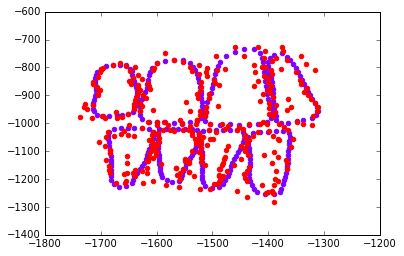

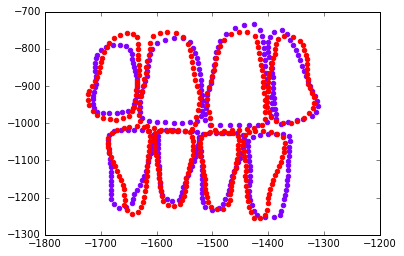

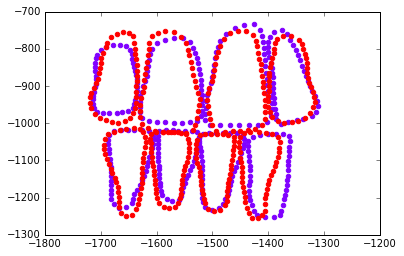

0.755214205186 0.766681896461 0.734762246843


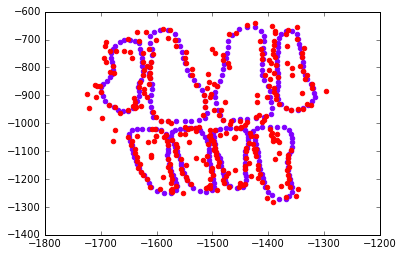

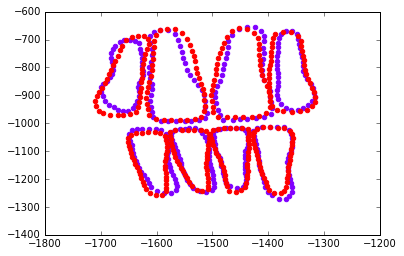

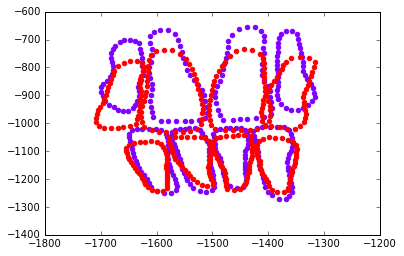

0.743606588465 0.791190357012 0.597720554508


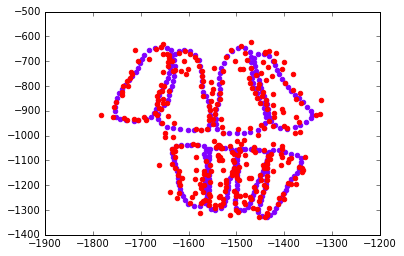

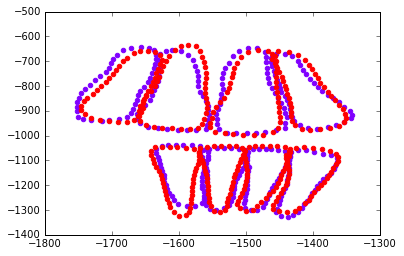

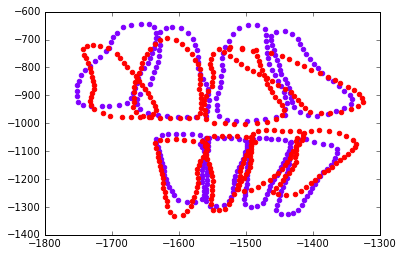

0.748781315175 0.775934583768 0.60296118306


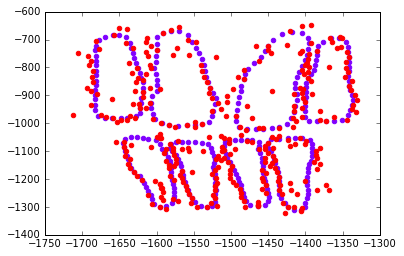

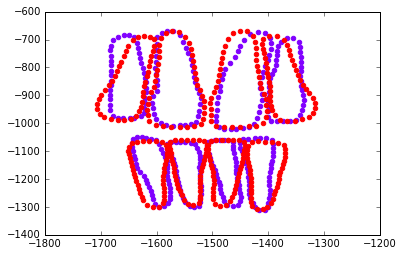

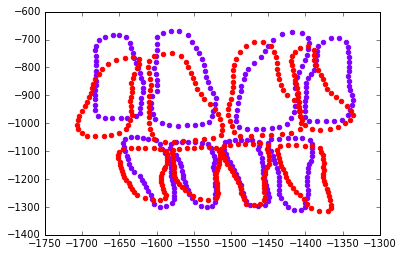

0.762755489361 0.690812255593 0.513033055126


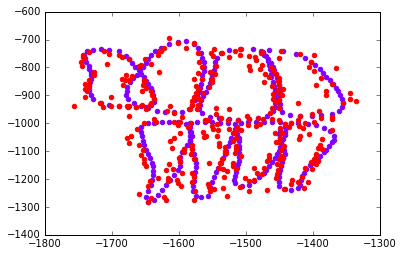

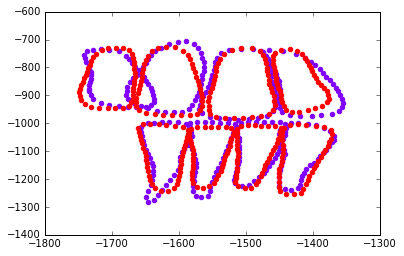

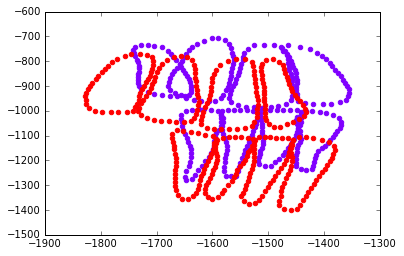

0.725621524253 0.776885882903 0.355575991155


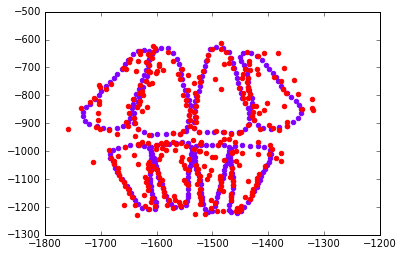

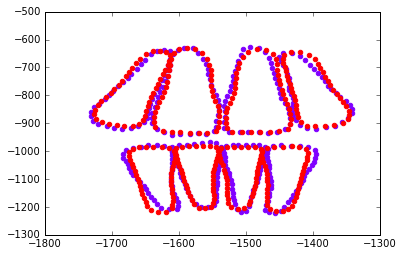

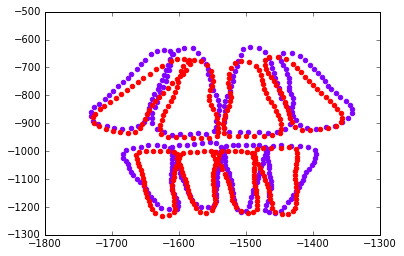

0.76250731783 0.838991363606 0.658609196057


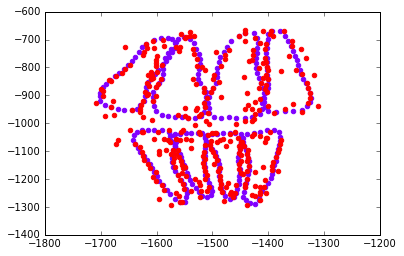

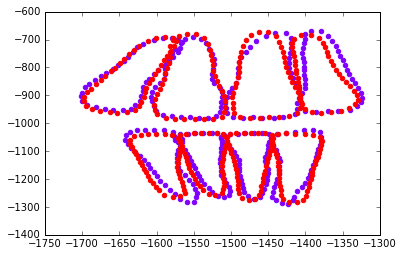

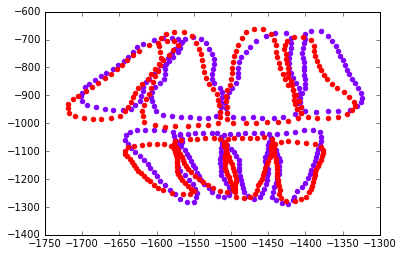

0.759575215419 0.799865163489 0.631450282152


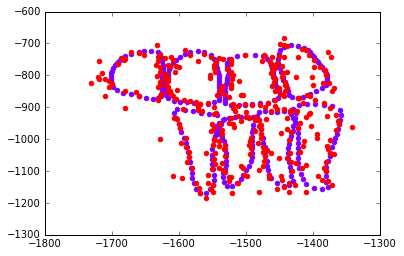

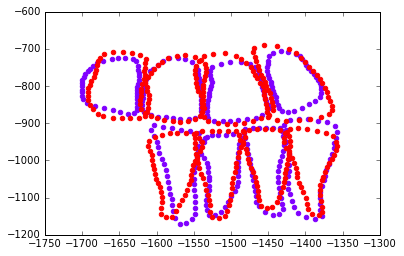

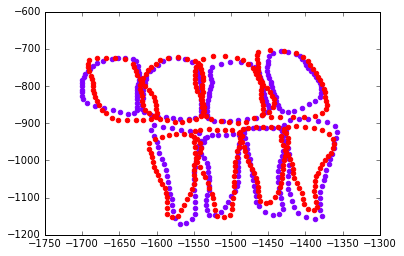

0.737428197118 0.703767173306 0.712574303625


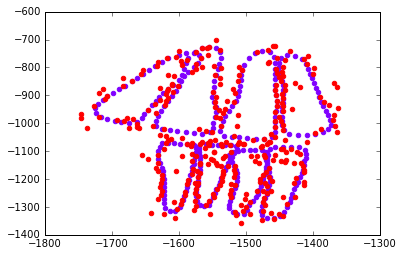

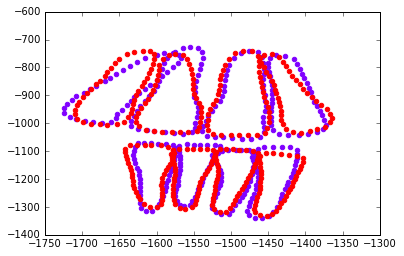

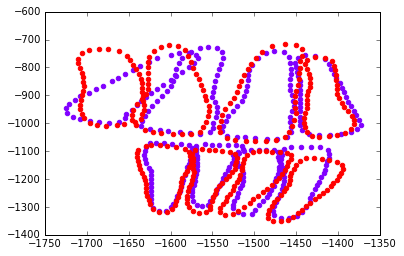

0.745426498403 0.742862987358 0.678141406285


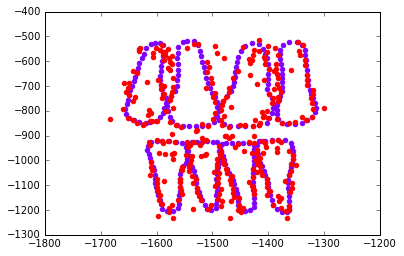

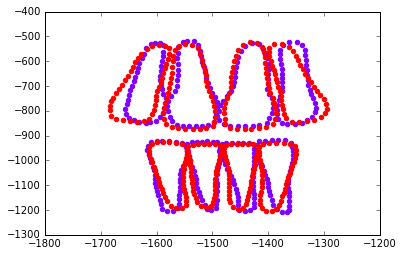

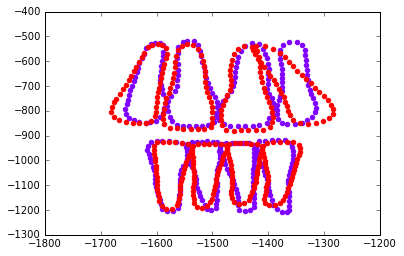

0.729320484707 0.731941642394 0.7085454391


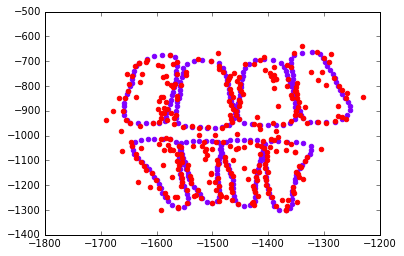

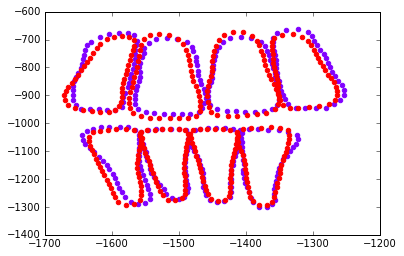

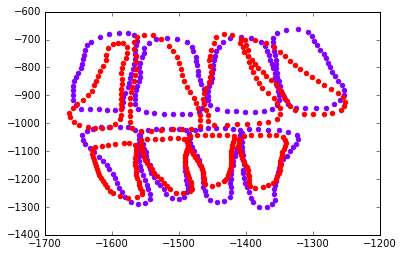

0.772672676316 0.818031716303 0.555702955366


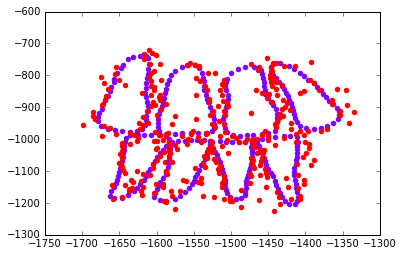

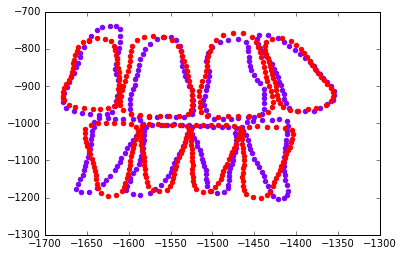

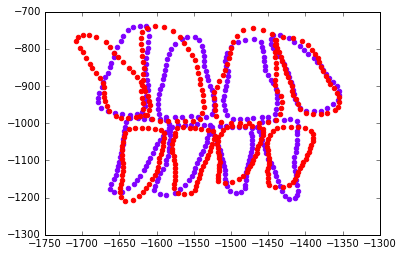

0.700469236148 0.700051129972 0.596954709853


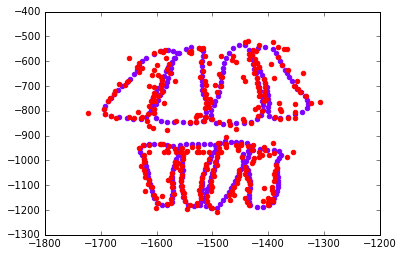

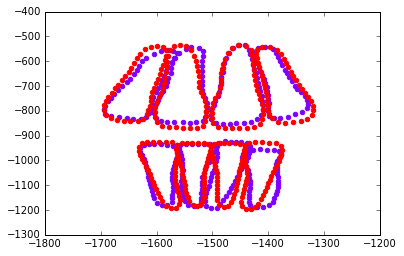

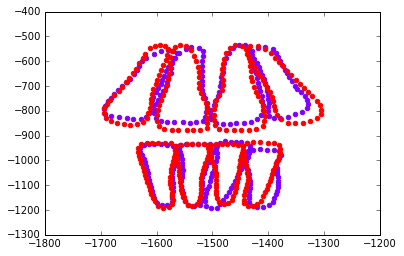

0.782978661082 0.768180363677 0.748628668486


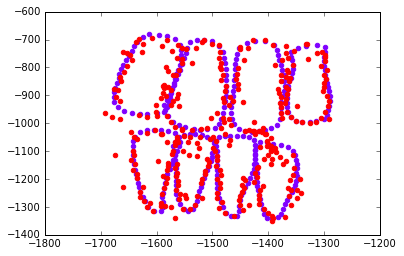

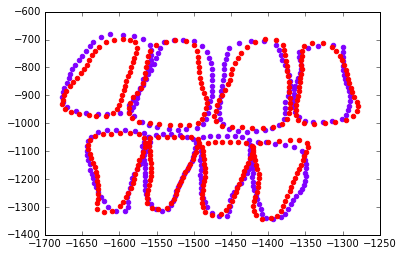

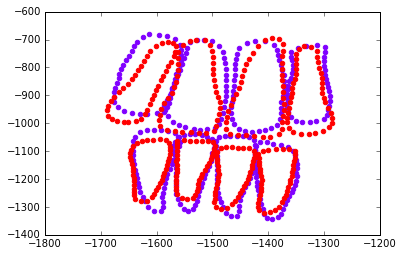

0.797078826424 0.784098754359 0.663881664683


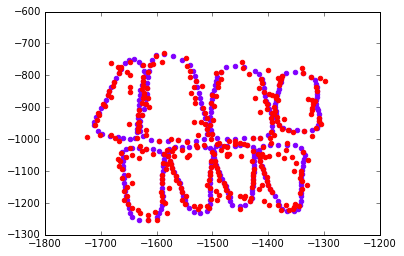

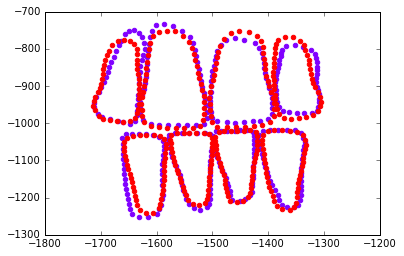

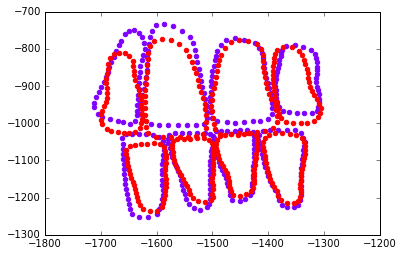

0.808411452471 0.842717536226 0.725945349554
0.632299133724


In [2]:
error_list = [];
i = 0
for split in LeaveOneOutSplitter(data,Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    transformed_test_image = test_image
    transformed_training_images = training_images
    #transformed_training_images = [cv2.Laplacian(image,ddepth=cv2.CV_32F) for image in scaled_training_images]
    #transformed_test_image = cv2.Laplacian(scaled_test_image,ddepth=cv2.CV_32F)
    transformed_training_images = [cv2.medianBlur(image,7) for image in transformed_training_images]
    transformed_test_image = cv2.medianBlur(transformed_test_image,7)
    shape_model = PointDistributionModel(training_landmarks,use_transformation_matrix=True,project_to_tangent_space=True)
    grey_model = GreyModel(transformed_training_images, training_landmarks,patch_num_pixels=30, 
                           search_num_pixels=60, use_gradient=True,
                 normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
                 normal_point_neighborhood=2)
    active_shape_model = ActiveShapeModel(shape_model,grey_model)
    new_shape,_= grey_model.search(transformed_test_image,test_landmark)
    newer_shape,_,_ = shape_model.fit(new_shape)
    newest_shape,_,_ = active_shape_model.fit(transformed_test_image,initial_shape=test_landmark)
    plot_shapes([test_landmark,new_shape])
    plot_shapes([test_landmark,newer_shape])
    plot_shapes([test_landmark,newest_shape])
    print split.get_dice_error_on_test(new_shape),split.get_dice_error_on_test(newer_shape),split.get_dice_error_on_test(newest_shape)
    error_list.append(split.get_dice_error_on_test(newest_shape))
    i = i+1
    if i >= 1:
        pass#break
print np.mean(np.array(error_list))